# PipeTorch Model module

The model module provides a few generic architectures, making it easy to instantiate a Multilayer Perceptron or a Convolutional Network. Regardless, often you may want to try something else, therefore, the data and train modules also work with a self-written PyTorch model.

We we cover training in the following topics:
- [Multi-layer Perceptron](#Multi-layer-Perceptron)
- [Convolutional Network](#Convolutional-Network)
- [Transfer Learning](#Transfer-Learning)

# Multi-layer Perceptron

Class that implements a generic MultiLayerPerceptron
```
Args:
    *with: int
        Sequence of at least two ints, that provide the widths for all the layers in the network.
        The first width should match the number of input features, the last width should match the
        numbetr of target variables (usually 1).

    preprocess: func (identity)
        function that will be used on the input first. The default means no preprocessing

    inner_activation: func (nn.ReLU())
        activation function that is used on all layers except the output

    drop_prob: float (None)
        if provided, Dropout layers are added in between all layers but the last, with a fixed
        dropout probability.

    last_activation: func (None)
        the activation function used on the last layer. The most common choices are None for regression
        nn.Sigmoid() for binary classification and nn.Softmax() for multi-label classification.
```

In [1]:
from pipetorch.data import DFrame, dam_outflow
from pipetorch.model import MultiLayerPerceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

using gpu 1


In [2]:
df = dam_outflow()
df = df.split(0.2).scale()
db = df.to_databunch(batch_size=32)

In [3]:
model = MultiLayerPerceptron(1, 100, 1)   # 6 features, 1 target, hidden layer 100

In [4]:
t = Trainer(model, nn.MSELoss(), db, metrics=r2_score)

In [5]:
t.train(100, 1e-2, cycle=10)

Total:   0%|          | 0/6510 [00:00<?, ?it/s]

 10 0.08s trainloss=0.11894 validloss=0.39676 r2_score=0.79976 
 20 0.05s trainloss=0.05492 validloss=0.15863 r2_score=0.91994 
 30 0.04s trainloss=0.04526 validloss=0.14657 r2_score=0.92603 
 40 0.04s trainloss=0.04125 validloss=0.11352 r2_score=0.94271 
 50 0.04s trainloss=0.03919 validloss=0.12289 r2_score=0.93798 
 60 0.04s trainloss=0.03865 validloss=0.10613 r2_score=0.94644 
 70 0.04s trainloss=0.03860 validloss=0.09646 r2_score=0.95132 
 80 0.04s trainloss=0.03663 validloss=0.08710 r2_score=0.95604 
 90 0.04s trainloss=0.03571 validloss=0.08476 r2_score=0.95722 
100 0.04s trainloss=0.03610 validloss=0.07799 r2_score=0.96064 


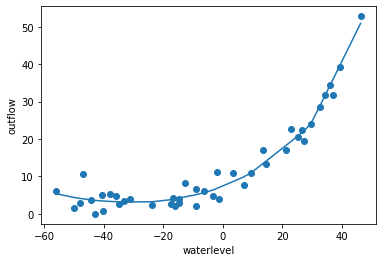

In [6]:
df.train.scatter()
df.train.line(y=model)

# Convolutional Networks

In [7]:
from pipetorch.model import ConvNet
from pipetorch.image import mnist
from pipetorch.train import *
from sklearn.metrics import accuracy_score
from torch import nn

# Data

For Image procesing there are a few standard collection: MNist and CIFAR. These are used for experiments so often, that they are included in the TorchVision library. However, processing them is not very efficient, therefore we followed the guidelines of FastMNIST (https://github.com/y0ast/pytorch-snippets/tree/main/fast_mnist) to speed up processing by 2x-3x.

These fast versions of MNist and Cifar can be obtained through the `mnist()`, `mnist3()` and `cifar()` loaders in `pipetorch.image`. The difference between mnist() and mnist3() is the number of channels (resp. 1 and 3). The first is faster the use, but the second is compatible with existing RGB models for transfer learning. 

# mnist()

An image_databunch of the mnist dataset in greyscale (shape is (1,28,28).
```
Args:
    test: bool (False)
        if True, the test set is also included in the Databunch

    valid_perc: float (0.1)
        the size of the train set that is used for validation

    root=None, transform=None, size=None, normalize=True, **kwargs
        see FastMNIST for documentation

    batch_size=64, num_workers=2
        see ImageDatabunch for documentation
    
Returns: ImageDatabunch
    An extension to a Databunch that provides additional support for images, like image normalization,
    transformation and show_batch to show an example.    
```

In all cases, through these loaders you get an ImageDatabunch that wraps PyTorch Dataloaders for the train, valid and optionally test set.

The ImageDatabunch adds some functionality such as `show_batch()`. We opted to pre-normalize the images for faster loading, therefore, the colors of the images are off, but they are still recognizable.

In [8]:
db = mnist(download=True)

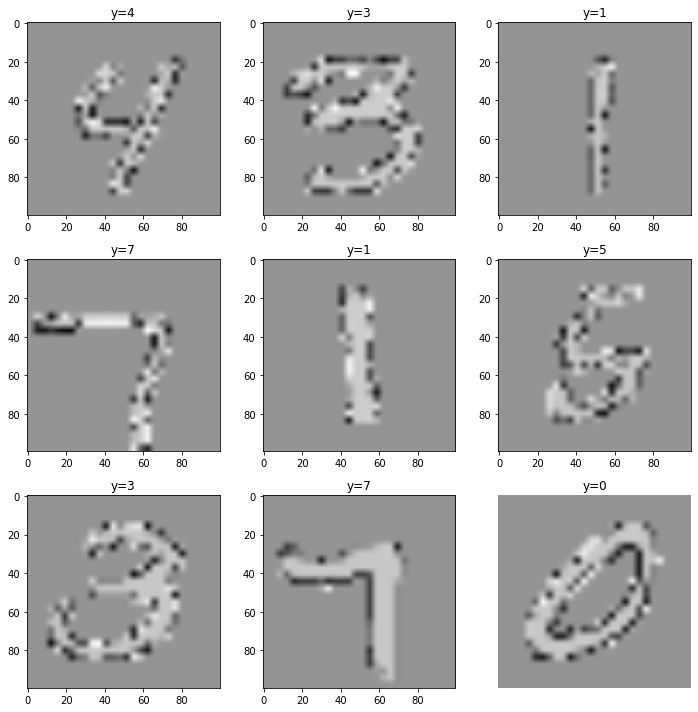

In [9]:
db.show_batch()

# ConvNet()

Construct a Convolutional Network based on the given parameters. The networks is always built up as
a sequence of Convolutional layers, followed by a sequence of Linear layers. The number of pixels 
at the end of the convolutional layer is automatically computed, and the final layer is automatically added.
```
Args:
    *layers: int
        one or more channel sizes that are used for the convolutional layers. e.g for 
        RGB images (3 channels) that are processed by two convolutional layers of 
        resp. 32 and 64 filters, set layers to 3, 32, 64.

    size: int or (int, int) (default 224)
        the height and width of the images. When squared images are used, one number is enough.

    kernel_size: int or (int, int) (default 3)
        the height and width of the kernel used in the nn.Conv2d layers.

    stride: int or (int, int) (default 1)
        the stride used in the nn.Conv2d layers

    padding: int or (int, int) (default None)
        the padding used in de nn.Conv2d layers, None means kern_size // 2 is used

    pool_size: int or (int, int) (default 2)
        the kernel size used in nn.MaxPool2d

    pool_stride: int or (int, int) (default 2)
        the stride used in nn.MaxPool2d

    preprocess: func (None)
        a function that is called on X prior to feeding the input to the first layer.

    batchnorm: bool (False)
        if True, then nn.BatchNorm2d are added to every concolutional layer

    linear: int or [int] ([])
        the convolutional network is always finished by one or more linear layers. 
        The default adds a single linear layer, automatically computing the number of pixels 
        after the last convolutional layer, no information is needed except num_classes. 
        Alternatively, a single int adds two linear layers where the int is the hidden size. 
        Or when linear is a list, the list contains the hidden layer sizes of consecutive 
        hidden layers.

    num_classes: int (default 1)
        the number of outputs

    final_activation: func (None)
        the activation function on the ouput layer. If None and num_classes == 1, 
        binary classification is assumed and a nn.Sigmoid is added, otherwise 
        a multi-label classification is assumed and no final activation function is added. 
        You can override by providing a final activation function, or if no activation 
        is needed with num_classes==1 pass final_activation=lambda x:x
```

In [10]:
model = ConvNet(1, 16, 32, size=28, num_classes=10)

In [11]:
model

ConvNet(
  (layer_2): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer_4): Linear(in_features=1568, out_features=10, bias=True)
)

In [12]:
t = Trainer(model, nn.CrossEntropyLoss(), db, metrics=accuracy_score, gpu=True)

In [13]:
t.train(10, lr=(3e-3, 3e-2))

Total:   0%|          | 0/600320 [00:00<?, ?it/s]

 1 4.36s trainloss=0.28408 validloss=0.05740 accuracy_score=0.98267 
 2 4.04s trainloss=0.05732 validloss=0.04208 accuracy_score=0.98800 
 3 4.04s trainloss=0.04314 validloss=0.03883 accuracy_score=0.98917 
 4 4.29s trainloss=0.03679 validloss=0.03770 accuracy_score=0.98967 
 5 4.01s trainloss=0.03054 validloss=0.03417 accuracy_score=0.99033 
 6 4.18s trainloss=0.02683 validloss=0.03702 accuracy_score=0.98900 
 7 4.12s trainloss=0.02300 validloss=0.03274 accuracy_score=0.99083 
 8 4.16s trainloss=0.02084 validloss=0.03702 accuracy_score=0.99050 
 9 4.21s trainloss=0.01877 validloss=0.03502 accuracy_score=0.99033 
10 4.15s trainloss=0.01640 validloss=0.03700 accuracy_score=0.99083 


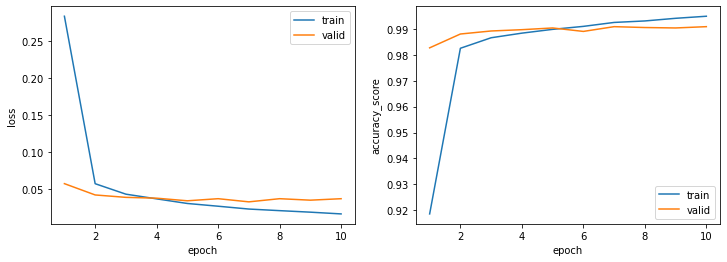

In [14]:
t.curves()

# ConvNet

As second example is for training a ConvNet on a Kaggle Dataset, with data augmentation.

In [15]:
from pipetorch.model import ConvNet, Transfer
from pipetorch.image import ImageDFrame
from pipetorch.train import *
from sklearn.metrics import accuracy_score
from torchvision.models import resnet34
from torchvision import transforms
from torch import nn

In this case, we will load a Kaggle image dataset with a class-folder structure using Torchvisions's ImageFolder. The filename 'Rice_Image_Dataset' indicates the root folder of the image collection. Below this folder there are folders with the names of class labels. The ImageDFrame is an extension of a PipeTorch DataFrame that initially holds the filenames and class numbers of the images.

In [16]:
df = ImageDFrame.read_from_kaggle('muratkokludataset/rice-image-dataset', 'Rice_Image_Dataset')

In [17]:
df.classes

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [18]:
df[:5]

,filename,target
0,/home/jeroen/.pipetorchuser/rice-image-dataset...,0
1,/home/jeroen/.pipetorchuser/rice-image-dataset...,0
2,/home/jeroen/.pipetorchuser/rice-image-dataset...,0
3,/home/jeroen/.pipetorchuser/rice-image-dataset...,0
4,/home/jeroen/.pipetorchuser/rice-image-dataset...,0


Most specifically for images, we can also normalize the images (which we did not do here, because it does not seem to matter on this dataset) and apply transformations from torchvision (data augmentation). The original images are 250x250 pixels, which we choose the resize to 224x224 because that makes it easier to process with a ConvNet.

In [19]:
df = df.split(0.02, shuffle=True).normalize(False)
df = df.transforms(
    transforms.RandomRotation(45),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
)

db = df.to_databunch()

We can show a batch to get an impression. These are 250x250 pixel images of rice grains and the objective is te recognize what type of rice grain these are.

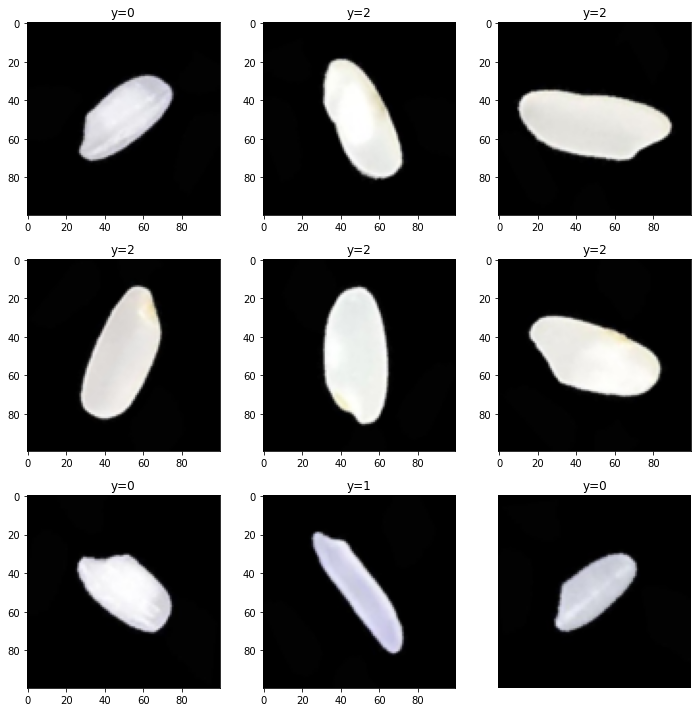

In [20]:
db.show_batch()

We can fit a standard ConvNet. We have to specify the image dimensions in `size`, the first channel size has to be `3` because these are RGB images, and `num_classes=5` because there are 5 classes.

In [21]:
model = ConvNet(3, 16, 32, linear=100, num_classes=5, size=224)

In [22]:
model

ConvNet(
  (layer_2): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer_4): Sequential(
    (0): Linear(in_features=100352, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer_5): Linear(in_features=100, out_features=5, bias=True)
)

Create a trainer as normal. Do not forget to turn the GPU on, it matters.

In [23]:
t = Trainer(model, nn.CrossEntropyLoss(), db, metrics=accuracy_score, num_workers=2, gpu=True)

Because of the size of this dataset (75k), we may choose to validate every 1/10 epoch, so that we receive an early indication whether the model is training as expected. We also lowered the validation percentage (0.02) to reduce the overhead of running validation, at least during hyperparameter tuning. You may decide to raise the the validation percentage after the hyperparameters are (close to) optimally tuned.

You may see a 99%+ accuracy. The upper bound seems to be around 99.7% using a new ConvNet.

In [24]:
t.train(3, (1e-3, 1e-2), cycle=1/10)

Total:   0%|          | 0/265632 [00:00<?, ?it/s]

1.10 39.84s trainloss=0.42374 validloss=0.11057 accuracy_score=0.96200 
1.20 38.99s trainloss=0.14844 validloss=0.08910 accuracy_score=0.96867 
1.30 34.44s trainloss=0.11962 validloss=0.08035 accuracy_score=0.97267 
1.40 35.30s trainloss=0.10936 validloss=0.08024 accuracy_score=0.97333 
1.50 36.15s trainloss=0.10283 validloss=0.06647 accuracy_score=0.97600 
1.60 35.97s trainloss=0.10893 validloss=0.07799 accuracy_score=0.97400 
1.70 35.93s trainloss=0.08951 validloss=0.07344 accuracy_score=0.97800 
1.80 37.53s trainloss=0.09592 validloss=0.08272 accuracy_score=0.97200 
1.90 36.33s trainloss=0.10278 validloss=0.06978 accuracy_score=0.98200 
2.00 37.02s trainloss=0.08559 validloss=0.06464 accuracy_score=0.97867 
2.10 33.34s trainloss=0.08282 validloss=0.06911 accuracy_score=0.98067 
2.20 32.53s trainloss=0.08430 validloss=0.06715 accuracy_score=0.97933 
2.30 34.23s trainloss=0.07976 validloss=0.05597 accuracy_score=0.98467 
2.40 32.42s trainloss=0.08466 validloss=0.06754 accuracy_score=0

# Transfer Learning

Often, the amount of available data is limited, forcing us to simplify the model used (to avoid overfitting). The downside of a simple model is that a limited amount of useful representations will be recognized. We can often overcome this by applying transfer learning.

To make transfer learning easier, there is a `Transfer` class in `pipetorch.models`. This can be instantiated with a pretrained model, for example from `torchvision.models`. The standard approach to transfer learning is to replace the final layer with a Linear and the given number of output nodes. Then we train the model in two phases: 
- (1) freeze the weights of the pretrained model and train the newly created final layer on the dataset, 
- (2) unfreeze the weights and finetune all the weights. 

During phase (1) we can train more aggresively with a higher learning rate, since overfitting is not that much of an issue learning weights in a single layer. During phase (2), we should be very careful not to overfit the network and therefore use a tiny (cyclic) learning rate. In general, cyclic learning rates tend to find wider local optima, and therefore may provide a slightly more stable training.

In [25]:
from pipetorch.model import Transfer
from pipetorch.image import ImageDFrame
from pipetorch.train import *
from sklearn.metrics import accuracy_score
from torchvision.models import resnet34
from torchvision import transforms
from torch import nn

In [26]:
df = ImageDFrame.read_from_kaggle('muratkokludataset/rice-image-dataset', 'Rice_Image_Dataset')

We will use the same setup as for training a ConvNet, to compare the two.

In [27]:
df = df.split(0.02, shuffle=True).normalize(False)
df = df.transforms(
    transforms.RandomRotation(45),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
)

db = df.to_databunch()

In [28]:
model = Transfer(model=resnet34, output_nodes=5)

In [29]:
model.freeze()

In [30]:
t = Trainer(model, nn.CrossEntropyLoss(), db, metrics=accuracy_score, num_workers=2, gpu=True)

In [31]:
t.train(1, (3e-3, 3e-2), cycle=1/10, save_lowest=True)

Total:   0%|          | 0/88544 [00:00<?, ?it/s]

1.10 34.11s trainloss=0.48505 validloss=0.20173 accuracy_score=0.94333 
1.20 34.04s trainloss=0.20334 validloss=0.12909 accuracy_score=0.96333 
1.30 34.69s trainloss=0.17137 validloss=0.11725 accuracy_score=0.95067 
1.40 34.15s trainloss=0.15008 validloss=0.12405 accuracy_score=0.95467 
1.50 34.12s trainloss=0.13867 validloss=0.10576 accuracy_score=0.96200 
1.60 34.08s trainloss=0.13134 validloss=0.10209 accuracy_score=0.96667 
1.70 34.46s trainloss=0.13553 validloss=0.09169 accuracy_score=0.96933 
1.80 34.54s trainloss=0.11347 validloss=0.07042 accuracy_score=0.97867 
1.90 34.13s trainloss=0.12081 validloss=0.08305 accuracy_score=0.97133 
2.00 33.95s trainloss=0.11173 validloss=0.07819 accuracy_score=0.97267 


In [32]:
# revert to the version with the lowest validation loss
t.lowest()

In [33]:
model.unfreeze()

In [34]:
t.train(2, (3e-6, 3e-5), cycle=1/10)

Total:   0%|          | 0/177088 [00:00<?, ?it/s]

2.10 44.92s trainloss=0.08653 validloss=0.04838 accuracy_score=0.98533 
2.20 44.52s trainloss=0.05733 validloss=0.03916 accuracy_score=0.98800 
2.30 44.77s trainloss=0.04752 validloss=0.02974 accuracy_score=0.98800 
2.40 45.25s trainloss=0.03446 validloss=0.02118 accuracy_score=0.99400 
2.50 44.67s trainloss=0.03308 validloss=0.01306 accuracy_score=0.99533 
2.60 44.84s trainloss=0.02615 validloss=0.01183 accuracy_score=0.99733 
2.70 45.10s trainloss=0.02667 validloss=0.01447 accuracy_score=0.99600 
2.80 44.94s trainloss=0.02131 validloss=0.01488 accuracy_score=0.99600 
2.90 44.69s trainloss=0.01834 validloss=0.01158 accuracy_score=0.99667 
3.00 44.73s trainloss=0.02268 validloss=0.00597 accuracy_score=0.99800 
3.10 44.76s trainloss=0.01507 validloss=0.00615 accuracy_score=0.99800 
3.20 44.53s trainloss=0.01339 validloss=0.00906 accuracy_score=0.99800 
3.30 44.72s trainloss=0.02046 validloss=0.00521 accuracy_score=0.99867 
3.40 44.70s trainloss=0.01541 validloss=0.00643 accuracy_score=0

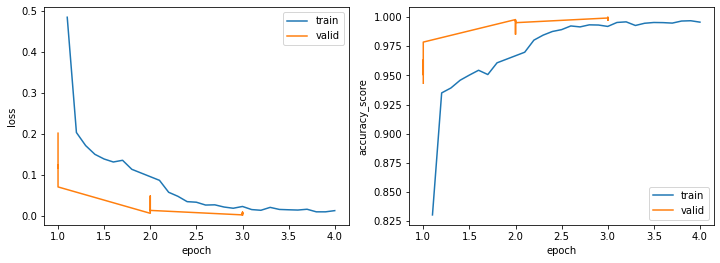

In [35]:
t.curves()